In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914833,72.676462,71.689973,71.847133,146322800
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200
2020-01-07,72.146950,72.753831,71.926922,72.497537,108872000
2020-01-08,73.307518,73.609752,71.849540,71.849540,132079200
...,...,...,...,...,...
2025-05-19,208.779999,209.479996,204.259995,207.910004,46140500
2025-05-20,206.860001,208.470001,205.029999,207.669998,42496600


<Axes: xlabel='Date'>

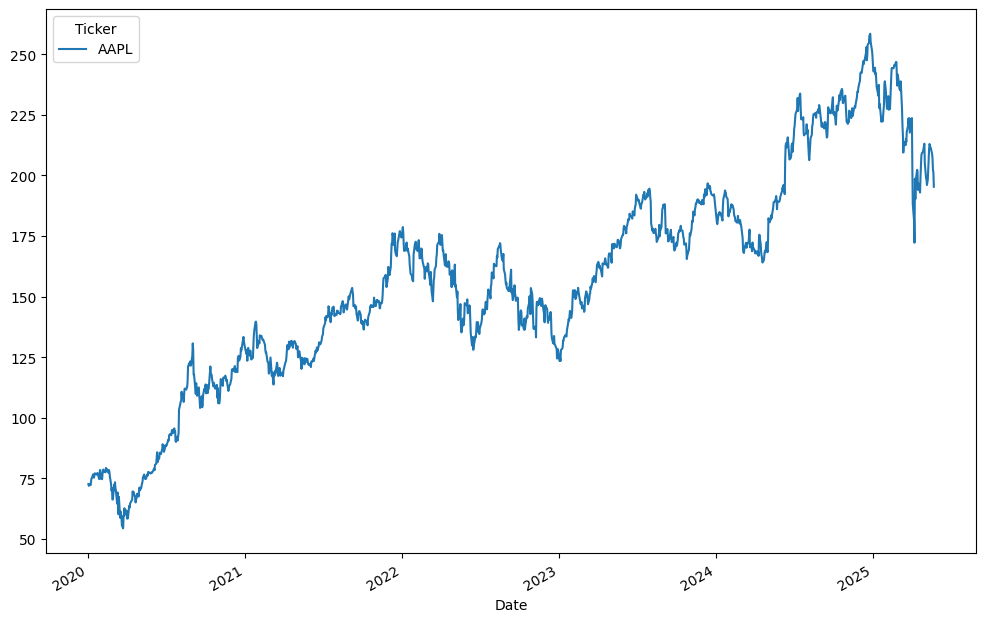

In [5]:
df.Close.plot(figsize=(12, 8))

In [6]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])

In [7]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.899030
2020-01-03,-1.914937
2020-01-06,-1.902026
2020-01-07,-1.909707
2020-01-08,-1.883558
...,...
2025-05-19,1.168806
2025-05-20,1.125546
2025-05-21,1.018072


In [8]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i: i+seq_length])

data = np.array(data)

In [9]:
data

array([[[-1.89902974],
        [-1.914937  ],
        [-1.9020263 ],
        ...,
        [-1.78997343],
        [-1.74852701],
        [-1.76125052]],

       [[-1.914937  ],
        [-1.9020263 ],
        [-1.90970712],
        ...,
        [-1.74852701],
        [-1.76125052],
        [-1.76081321]],

       [[-1.9020263 ],
        [-1.90970712],
        [-1.88355807],
        ...,
        [-1.76125052],
        [-1.76081321],
        [-1.79330484]],

       ...,

       [[ 0.34448223],
        [ 0.93920321],
        [ 0.74951352],
        ...,
        [ 1.22468336],
        [ 1.16880596],
        [ 1.12554601]],

       [[ 0.93920321],
        [ 0.74951352],
        [ 0.92345169],
        ...,
        [ 1.16880596],
        [ 1.12554601],
        [ 1.01807186]],

       [[ 0.74951352],
        [ 0.92345169],
        [ 1.02178455],
        ...,
        [ 1.12554601],
        [ 1.01807186],
        [ 1.00162414]]], shape=(1326, 30, 1))

In [10]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[: train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [11]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
    
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out


In [12]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
num_epochs = 200

for i in range(num_epochs): 
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6407474279403687
25 0.011276714503765106
50 0.00590857770293951
75 0.005178548861294985
100 0.0047586895525455475
125 0.004405338317155838
150 0.004124382045120001
175 0.0038822416681796312


In [15]:
model.eval()
y_test_pred = model(X_test)


y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [16]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [17]:
train_rmse

2.694866180419922

In [18]:
test_rmse

5.796627998352051

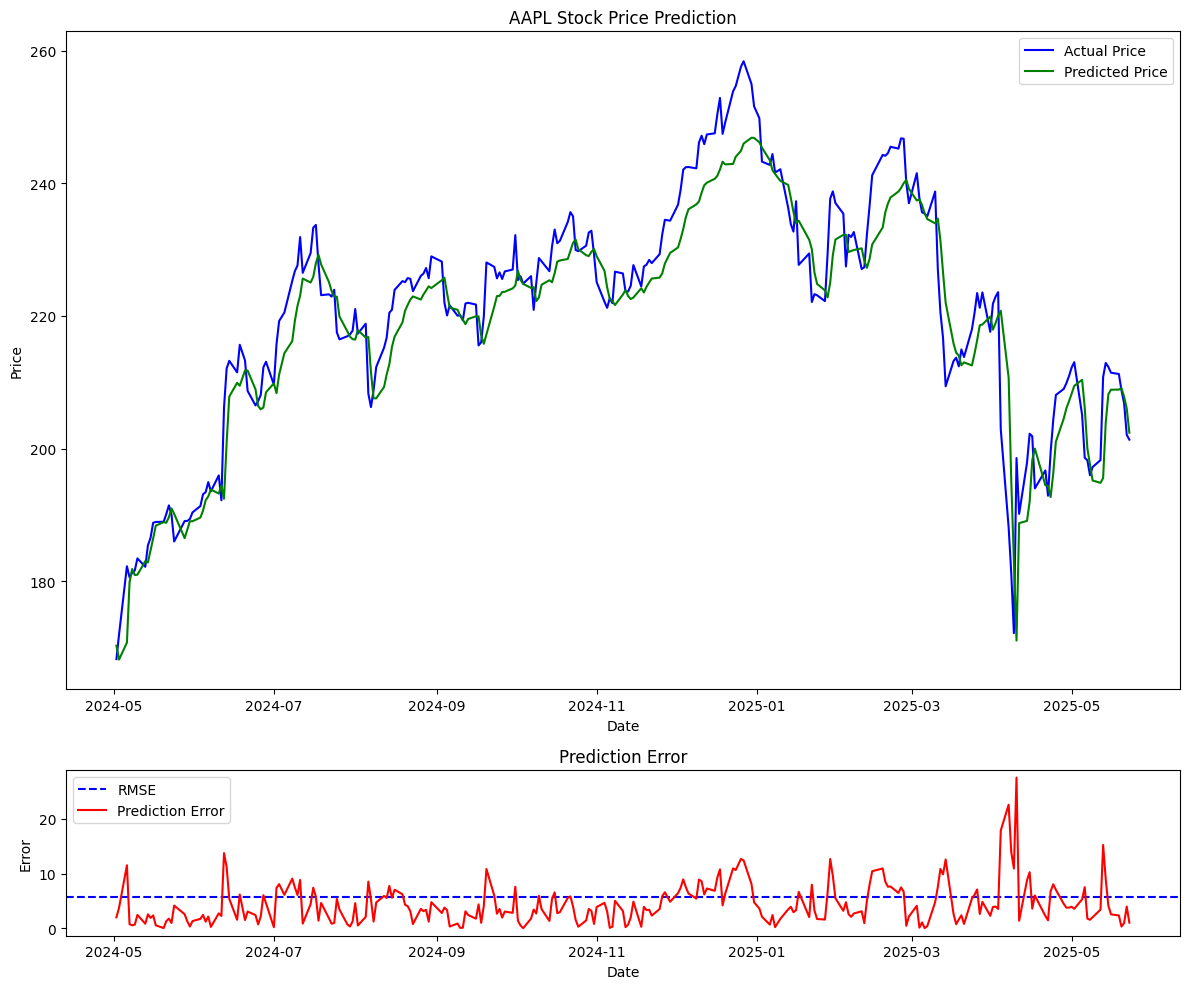

In [19]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label="Actual Price")
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label = "Predicted Price")

ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")


ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color="blue", linestyle='--', label="RMSE")
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label="Prediction Error")
ax2.legend()

plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()

plt.show()